# Planning Trajectories via RRT

At this point you should have understood how you can deal with Signal temporal Logic formulas and how to create simple maps and workspaces for your environment. At this point it is time to think about how to finally plan a trajectory that satisfies the given specifications. The way we approach the problem is by trasforming a task into a time varying polyhedron. At a very high-level for a task $\phi$ we create a time-varying polyhedron of the form 

$$
\mathcal{B}^{\phi}(t) = \{ x \mid D(t) x \leq b(t) \}.
$$ 

and we prove that every trajectory evolving within the time-varying polyhedron also satisfies the task $\phi$. If you want to have more details on how these time-varying polyhedrons are created, you can have a look into our publication. After the set is created, we can use it inside a Model Predictive Control framework to steer the system while remiain within the time varying set $\mathcal{B}^{\phi}(t)$. The optimization problem will look something like:


$$
\begin{aligned}
\min_{\zeta_{u},\zeta_{x}} \int_{t_i}^{t_i+\Delta} \|\zeta_{x}(t)- \tilde{x}\|^2_{Q} +  \|\zeta_{u}(t)\|^2_{R} \; dt
\end{aligned}
$$
$$
\begin{aligned}
\zeta_{u}(t)&\in \mathbb{U},  &\forall t\in [t_i,t_j]  \\
\dot{\zeta}_{x}(t) &= A\zeta_{x}(t) + B\zeta_{u}(t) ,\; a.e.\; &t\in [t_i,t_j]  \\
\zeta_{x}(t) &\in \mathcal{B}^{\phi}(t),   &\forall t\in [t_i,t_j]\\
\zeta_{x}(t_i) &= x_0, 
\end{aligned}
$$

where $\tilde{x}$ is just target location toward which we would like to move. This is a kind of local controller that can be used inside a sampling-based trajectory planner to obtain compex trajectories avoiding obstacles in the environment. We next show a full example of how this could be done.

In [1]:
from   matplotlib import pyplot as plt
import numpy as np
np.random.seed(3)

from stl_tool.stl                     import GOp, FOp, TasksOptimizer, ContinuousLinearSystem, BoxBound2d
from stl_tool.environment             import Map
from stl_tool.polyhedron                import Box2d

from stl_tool.planners import StlRRTStar
from json import loads
import os 


##########################################################
# Create work space and mapo
##########################################################
workspace     = Box2d(x = 0,y = 0,size = 20) # square 20x20
map           = Map(workspace = workspace)

# load obstacles 
file_path = "maps/map2d_ex.json"
map_json = loads(open(file_path,mode="r").read())
map.read_from_json(file_path)
map.enlarge_obstacle(border_size=0.03) # enlarge obstacles

##########################################################
# system and dynamics
##########################################################
A             = np.random.rand(2,2)*0.1
B             = np.diag([1.5,1.5])
dt            = 1.
system        = ContinuousLinearSystem(A, B, dt = dt)
max_input     = 5.
input_bounds  = Box2d(x = 0.,y = 0.,size = max_input*2) 



Up to hear nothing new. We have just create a linear system and we put some obstacles in the map. We now create a task. We take the predicates also from the map file.

In [2]:

##########################################################
# STL specifications
##########################################################

named_map = {item["name"]: item for item in map_json}

# first interest point
intrest_point = named_map["interest_2"]
p1 = BoxBound2d(size = intrest_point["size_x"], center = np.array([intrest_point["center_x"], intrest_point["center_y"]]), name = "interest_1")
# second interest point
intrest_point = named_map["interest_6"]
p2 = BoxBound2d(size = intrest_point["size_x"], center = np.array([intrest_point["center_x"], intrest_point["center_y"]]), name = "interest_2")
# third interest point
intrest_point = named_map["interest_3"]
p3 = BoxBound2d(size = intrest_point["size_x"], center = np.array([intrest_point["center_x"], intrest_point["center_y"]]), name = "interest_3")

intrest_point = named_map["interest_4"]
p4 = BoxBound2d(size = intrest_point["size_x"], center = np.array([intrest_point["center_x"], intrest_point["center_y"]]), name = "interest_3")

# charging_station 
intrest_point = named_map["charging_station"]
c_station     = BoxBound2d(size = intrest_point["size_x"], center = np.array([intrest_point["center_x"], intrest_point["center_y"]]), name = "charging_station")

formula       =  (FOp(20,25) >> p1)  & (FOp(120,150) >> p2) & (GOp(0.01,200) >>  (FOp(0.01,100) >> c_station)) & (GOp(255,265) >> p3)




At this point we need to create hour time varying polytopes. To do so it is sufficient to call the `TaskOptimzer` class as in this example.

In [3]:

# # ##########################################################
# # # From STL to Barriers
# # ##########################################################
x_0       = c_station.polytope.sample_random() # generate a random start point from the charging station

scheduler = TasksOptimizer(formula, workspace,system) # create task optimizer
scheduler.make_time_schedule()                 # create scheduling of the tasks
solver_stats = scheduler.optimize_barriers( input_bounds = input_bounds, x_0 = x_0) # create barriers


#########################################################
# Create RRT solver
#########################################################
time_varying_constraints = scheduler.get_barrier_as_time_varying_polytopes()
# scheduler.show_time_varying_level_set(ax,t_start=0.,t_end = 9.99,n_points=20)


Enumerating tasks
Found Tasks of type:  F
Start time:  20.0
Duration:  5.001
---------------------------------------------
Found Tasks of type:  F
Start time:  120.0
Duration:  30.001
---------------------------------------------
Found Tasks of type:  F
Start time:  66.68333333333334
Duration:  166.69333333333333
---------------------------------------------
Found Tasks of type:  F
Start time:  133.3466666666667
Duration:  333.3466666666667
---------------------------------------------
Found Tasks of type:  F
Start time:  200.01000000000002
Duration:  500.0
---------------------------------------------
Found Tasks of type:  G
Start time:  255.0
Duration:  10.0
---------------------------------------------
====== Enumeration completed =============================================
========= Cheking for possible conflicting conjuncitons ==================
Times Schedule completed
Number of barrier functions created:  6
Times optimization status:  optimal
Listing alpha and beta values per 

  2%|▏         | 8/333 [00:00<00:39,  8.14it/s]

Barrier functions optimization result
Status                         :  optimal
Solver time                    :  0.007430022000335157
number of variables            :  237
Optimal Cost (expluding slack) : -4.852040273796261
Maximum Slack violation        :  0.0
Robustness                     :  0.0455862229025329
-----------------------------------------------------------
Listing parameters per task
Operator        :  F
Barrier alpha   :  19.999999947761964
Barrier beta    :  19.99999994773708
Barrier gamma_0 :  [8.97501696e+00 1.23250012e+01 3.12840258e-01 3.60982499e-12]
Barrier r       :  0.0455862229025329
---------------------------------------------------
Operator        :  F
Barrier alpha   :  120.00000098947181
Barrier beta    :  120.00000098941976
Barrier gamma_0 :  [ 7.02967598 31.84080679 19.02811608  0.39566664]
Barrier r       :  0.7565906328239237
---------------------------------------------------
Operator        :  F
Barrier alpha   :  66.68333365748741
Barrier beta   

The time varying polhedrons are just of the form 

$$
Dx + \leq b + ct
$$
where $t$ is the current time. More compactly this is written as
$$
[D, -c] \left[\begin{array}{c}x\\t \end{array} \right] \leq b 
$$

Indeed you can check that this is the form given to the constraints:

In [4]:
print(time_varying_constraints[0].H)
print(time_varying_constraints[0].b)

[[ 1.00000000e+00  0.00000000e+00  4.48750849e-01]
 [ 0.00000000e+00  1.00000000e+00  6.16250059e-01]
 [-1.00000000e+00  0.00000000e+00  1.56420130e-02]
 [ 0.00000000e+00 -1.00000000e+00  1.80491250e-13]]
[3.49756379 8.37320438 8.25529367 6.41679701]


The last column of the matrix $H$ represents the time variation. At this point we can put everything we need into our RRT planner and find a solution.

Initializing MPC controller for tree expansion...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...
Initializing MPC controller for tree rewiring...


100%|██████████| 2000/2000 [00:15<00:00, 130.59it/s]


Solution Summary:
Cost: 77.88964
Clock time: 7.64
Number of nodes: 55
Number of iterations: 1031
----------------------------------------------
Cost: 77.63668
Clock time: 7.74
Number of nodes: 55
Number of iterations: 1045
----------------------------------------------
Cost: 77.63250
Clock time: 9.74
Number of nodes: 55
Number of iterations: 1317
----------------------------------------------
Cost: 77.40683
Clock time: 10.27
Number of nodes: 55
Number of iterations: 1392
----------------------------------------------
Cost: 77.40591
Clock time: 10.74
Number of nodes: 55
Number of iterations: 1451
----------------------------------------------
Cost: 77.32328
Clock time: 10.84
Number of nodes: 55
Number of iterations: 1465
----------------------------------------------
Cost: 75.93451
Clock time: 11.61
Number of nodes: 55
Number of iterations: 1562
----------------------------------------------
Best solution*:
Best solution cost*: 75.93451
Best solution clock time*: 11.61
Best solution num

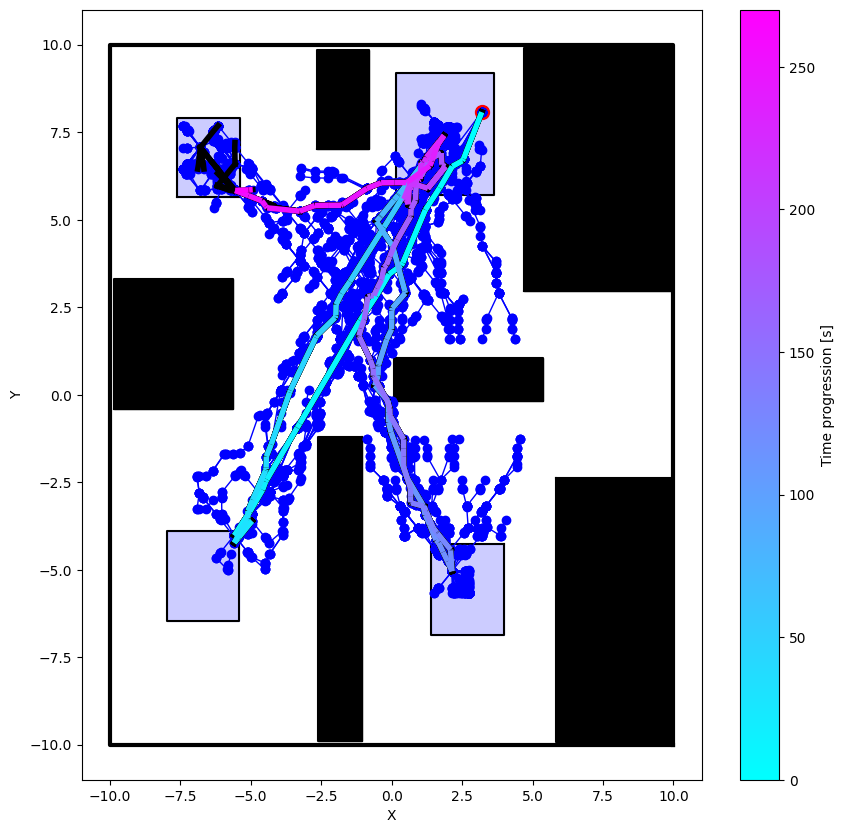

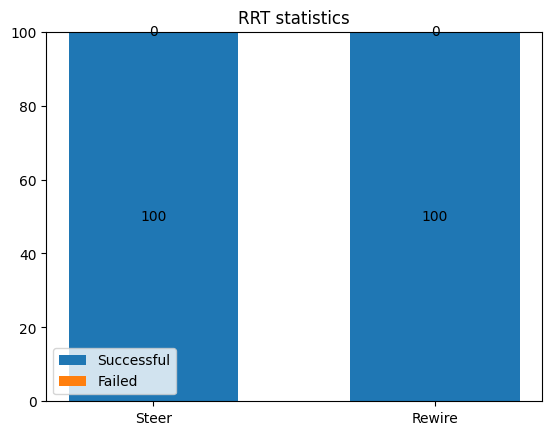

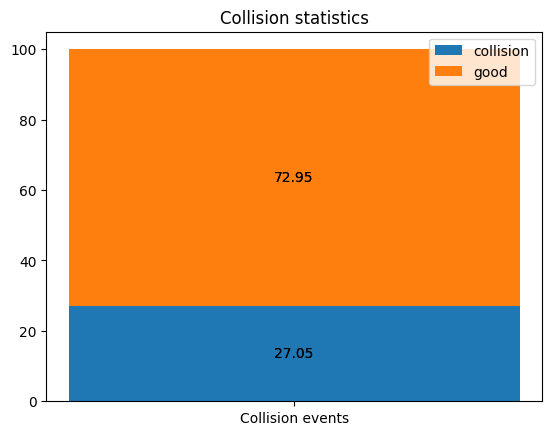

In [5]:

rrt_planner     = StlRRTStar(start_state     = x_0,
                            system           = system,
                            prediction_steps = 5, # MPC prediction steps
                            stl_constraints  = time_varying_constraints , # STL constraints
                            map              = map,
                            max_input        = max_input, # input bound for the MPC controller
                            max_iter         = 2000, # number of iterations
                            space_step_size  = 2.8, #(maximum expansion distance of the RRT)
                            rewiring_radius  = 25, # rewiring radius (the bigger and the more nodes are selected for rewiring. Too high values can slow down a lot the planning)
                            rewiring_ratio   = 2, # ratio of time rewiring is achived (in this case every other iteration. The higher the less times rewiring is done)
                            verbose          = True,
                            biasing_ratio    = 2.) # ratio of times you bias the sampling toward a good direction.

map.draw() # draw if you want :)
fig,ax = map.draw_formula_predicate(formula = formula, alpha =0.2)
rrt_planner.plan()
fig,ax = rrt_planner.plot_rrt_solution(ax = ax, solution_only= False)


ax.scatter(x_0[0], x_0[1], color='r', label='start', s=100)

rrt_planner.show_statistics()

plt.show()